<a href="https://colab.research.google.com/github/pcdanh/CS2225.CH1501/blob/master/phanloailua_Danh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
!wget --no-check-certificate \
https://raw.githubusercontent.com/pcdanh/CS2225.CH1501/master/data.zip \
    -O /tmp/data.zip

--2021-01-25 08:41:14--  https://raw.githubusercontent.com/pcdanh/CS2225.CH1501/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15498497 (15M) [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>]  14.78M  --.-KB/s    in 0.07s   

2021-01-25 08:41:14 (217 MB/s) - ‘/tmp/data.zip’ saved [15498497/15498497]



In [ ]:
import zipfile

local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

data_dir = '/tmp/lua'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)


BATCH_SIZE = 64

In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 74 images belonging to 3 classes.
Found 153 images belonging to 3 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Xây dựng model với", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Xây dựng model với https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
EPOCHS=20

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/20
2/2 [==============================] - 8s 3s/step - loss: 1.6852 - accuracy: 0.3282 - val_loss: 3.7680 - val_accuracy: 0.5312
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 1.8553 - accuracy: 0.7240 - val_loss: 2.0723 - val_accuracy: 0.4531
Epoch 3/20
2/2 [==============================] - 3s 2s/step - loss: 0.9690 - accuracy: 0.7494 - val_loss: 1.1130 - val_accuracy: 0.5781
Epoch 4/20
2/2 [==============================] - 3s 2s/step - loss: 0.6212 - accuracy: 0.7061 - val_loss: 0.9226 - val_accuracy: 0.5469
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 0.5362 - accuracy: 0.8021 - val_loss: 1.0071 - val_accuracy: 0.4844
Epoch 6/20
2/2 [==============================] - 3s 2s/step - loss: 0.5171 - accuracy: 0.7812 - val_loss: 1.1186 - val_accuracy: 0.5156
Epoch 7/20
2/2 [==============================] - 3s 1s/step - loss: 0.4707 - accuracy: 0.8154 - val_loss: 1.0723 - val_accuracy: 0.5156
Epoch 8/20
2/2 [=========================

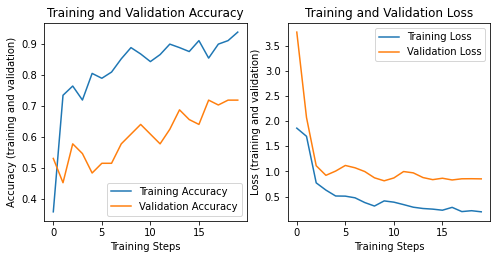

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
import json

with open('/tmp/lua/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bệnh bạc lá', 'Bệnh đạo ôn', 'Bệnh đốm nâu']


SOURCE: class: ('/tmp/lua/test/bacterial_leaf_blight', 'bacla1.jpg'), file: /tmp/lua/test/bacterial_leaf_blight/bacla1.jpg
Dự đoán: class: Bệnh bạc lá, confidence: 0.771897


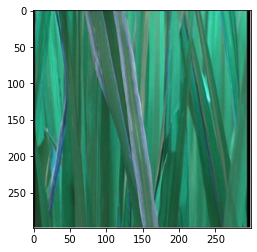

SOURCE: class: ('/tmp/lua/test/bacterial_leaf_blight', 'bacla2.jpg'), file: /tmp/lua/test/bacterial_leaf_blight/bacla2.jpg
Dự đoán: class: Bệnh bạc lá, confidence: 0.531066


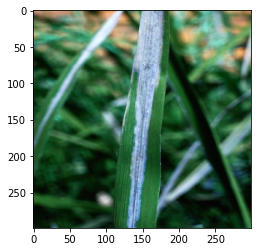

SOURCE: class: ('/tmp/lua/test/blast', '4.png'), file: /tmp/lua/test/blast/4.png
Dự đoán: class: Bệnh đạo ôn, confidence: 0.736756


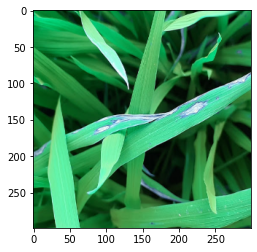

SOURCE: class: ('/tmp/lua/test/blast', '3.png'), file: /tmp/lua/test/blast/3.png
Dự đoán: class: Bệnh đạo ôn, confidence: 0.736756


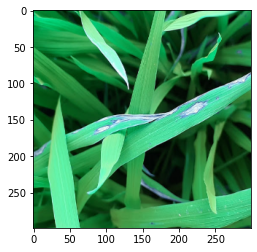

SOURCE: class: ('/tmp/lua/test/brownspot', '1.jpg'), file: /tmp/lua/test/brownspot/1.jpg
Dự đoán: class: Bệnh đốm nâu, confidence: 0.636414


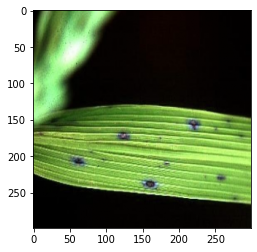

SOURCE: class: ('/tmp/lua/test/brownspot', '2.jpg'), file: /tmp/lua/test/brownspot/2.jpg
Dự đoán: class: Bệnh đốm nâu, confidence: 0.904884


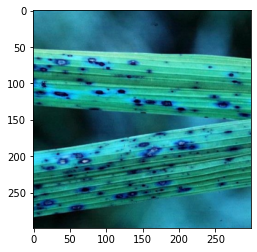

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}


def test(filename):
  print("SOURCE: class: %s, file: %s" % (os.path.split(filename), filename))
  img = load_image(filename)
  prediction = predict(img)
  print("Dự đoán: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0])) 
  plt.imshow(img)
  plt.show()

test('/tmp/lua/test/bacterial_leaf_blight/bacla1.jpg')
test('/tmp/lua/test/bacterial_leaf_blight/bacla2.jpg')
test('/tmp/lua/test/blast/4.png')
test('/tmp/lua/test/blast/3.png')
test('/tmp/lua/test/brownspot/1.jpg')
test('/tmp/lua/test/brownspot/2.jpg')


In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)